In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
    print(os.path.join(dirname))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/real-esrgan-weights
/kaggle/input/real-esrgan-weights/RealESRGAN_weights
/kaggle/input/div2k-high-resolution-images
/kaggle/input/div2k-high-resolution-images/DIV2K_valid_HR
/kaggle/input/div2k-high-resolution-images/DIV2K_valid_HR/DIV2K_valid_HR
/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR
/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR


Testing here

In [5]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.models import Model
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Enable Mixed Precision for Speedup
tf.keras.mixed_precision.set_global_policy('mixed_float16')

print("✅ TensorFlow Version:", tf.__version__)
print("✅ GPU Available:", tf.config.list_physical_devices('GPU'))


✅ TensorFlow Version: 2.17.1
✅ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
import numpy as np
import cv2
import glob

# Set Dataset Paths
train_hr_path = "/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR/*.png"
valid_hr_path = "/kaggle/input/div2k-high-resolution-images/DIV2K_valid_HR/DIV2K_valid_HR/*.png"



In [4]:
# Load High-Resolution Images
def load_images(image_paths, size=(256, 256)):
    images = []
    for img_path in sorted(glob.glob(image_paths)):  # ✅ Sort to ensure order
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        images.append(img.astype(np.float32) / 255.0)  # ✅ Normalize to [0,1]
    return np.array(images, dtype=np.float32)

# Load Dataset
train_hr = load_images(train_hr_path)
valid_hr = load_images(valid_hr_path)

print(f"✅ Loaded {len(train_hr)} Training Images & {len(valid_hr)} Validation Images")

# Generate Low-Resolution Images (Bicubic Downscaling)
def downscale_images(images, scale=2):
    lr_images = []
    for img in images:
        h, w, _ = img.shape
        img_lr = cv2.resize(img, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
        lr_images.append(img_lr.astype(np.float32))  # ✅ Ensure float32
    return np.array(lr_images, dtype=np.float32)

train_lr = downscale_images(train_hr, scale=2)
valid_lr = downscale_images(valid_hr, scale=2)

# Check Image Shapes
print(f"HR Shape: {train_hr.shape}, LR Shape: {train_lr.shape}")

# Reshape HR & LR Images to Match Model Input
train_lr = train_lr.reshape(-1, 128, 128, 3)  # ✅ Ensure correct shape
train_hr = train_hr.reshape(-1, 256, 256, 3)  # ✅ Ensure correct shape

valid_lr = valid_lr.reshape(-1, 128, 128, 3)
valid_hr = valid_hr.reshape(-1, 256, 256, 3)

print(f"✅ Reshaped HR: {train_hr.shape}, Reshaped LR: {train_lr.shape}")


✅ Loaded 800 Training Images & 100 Validation Images
HR Shape: (800, 256, 256, 3), LR Shape: (800, 128, 128, 3)
✅ Reshaped HR: (800, 256, 256, 3), Reshaped LR: (800, 128, 128, 3)


In [5]:
import tensorflow as tf
import keras.backend as K

# Define PSNR Metric
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Define SSIM Metric
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# # Compile Model (Use lambda functions to avoid metric interpretation errors)
# model.compile(
#     optimizer='adam',
#     loss='mse',
#     metrics=[
#         lambda y_true, y_pred: psnr_metric(y_true, y_pred),  # Lambda function
#         lambda y_true, y_pred: ssim_metric(y_true, y_pred)   # Lambda function
#     ]
# )


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda
from tensorflow.keras.models import Model

# Define ESPCN Model
def espcn_model(scale=2):
    inputs = Input(shape=(None, None, 3))
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(3 * (scale ** 2), (3, 3), activation='relu', padding='same')(x)
    x = Lambda(lambda x: tf.nn.depth_to_space(x, scale))(x)  # Subpixel Shuffle
    x = Lambda(lambda x: tf.cast(x, tf.float32))(x)  # ✅ Ensure output is float32
    model = Model(inputs, x)
    return model



import tensorflow as tf
import tensorflow.image as tfimg
import keras.backend as K

# Define PSNR Metric
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Define SSIM Metric
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)


# Initialize Model
model = espcn_model(scale=2)


model.compile(optimizer='adam', loss='mse', 
              metrics=['mse', 
                       tf.keras.metrics.MeanAbsoluteError(name='mae'), 
                       psnr_metric, 
                       ssim_metric])


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, None, None, 64)      │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, None, None, 12)      │           3,468 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, None, None, 3)       │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,796 (104.67 KB)

 Trainable params: 26,796 (104.67 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train Model
history = model.fit(
    train_lr, train_hr, validation_data=(valid_lr, valid_hr),
    batch_size=2, epochs=200, verbose=1
)

# Save Model
model.save("espcn_model.h5")
print("✅ Model Saved Successfully!")


Epoch 1/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0324 - mae: 0.1144 - mse: 0.0324 - psnr_metric: 17.4201 - ssim_metric: 0.4070 - val_loss: 0.0080 - val_mae: 0.0599 - val_mse: 0.0080 - val_psnr_metric: 21.6385 - val_ssim_metric: 0.7065
Epoch 2/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - mae: 0.0523 - mse: 0.0071 - psnr_metric: 22.3758 - ssim_metric: 0.7218 - val_loss: 0.0066 - val_mae: 0.0500 - val_mse: 0.0066 - val_psnr_metric: 22.6857 - val_ssim_metric: 0.7413
Epoch 3/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0066 - mae: 0.0494 - mse: 0.0066 - psnr_metric: 22.7309 - ssim_metric: 0.7453 - val_loss: 0.0066 - val_mae: 0.0503 - val_mse: 0.0066 - val_psnr_metric: 22.6900 - val_ssim_metric: 0.7433
Epoch 4/200
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0066 - mae: 0.0502 - mse: 0.0066 - psnr_metric: 22.7332 - ssim_metric: 0.7470 - val_loss: 0.0063 - val_mae: 0.0472 - val_mse: 0.0063 - val_psnr_metric: 22.9639 - val_ssim_metric: 0.7543
Epoc

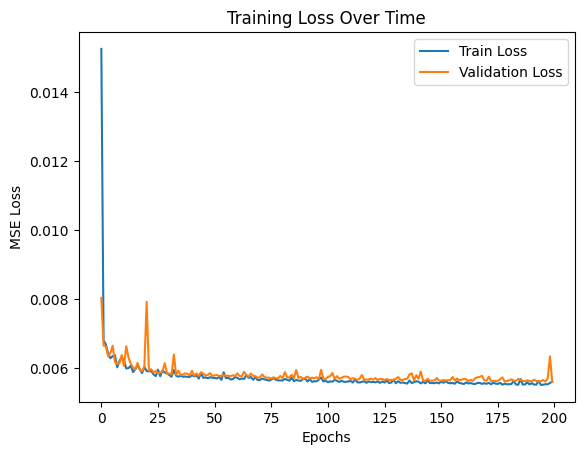

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


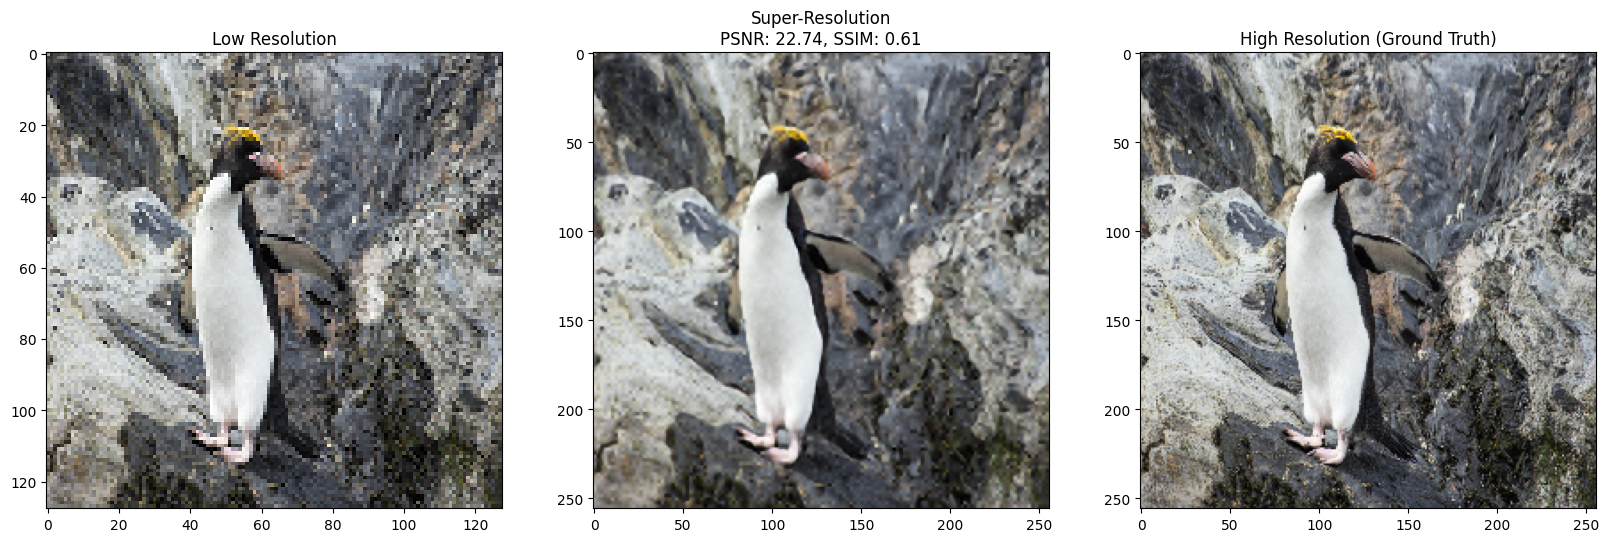

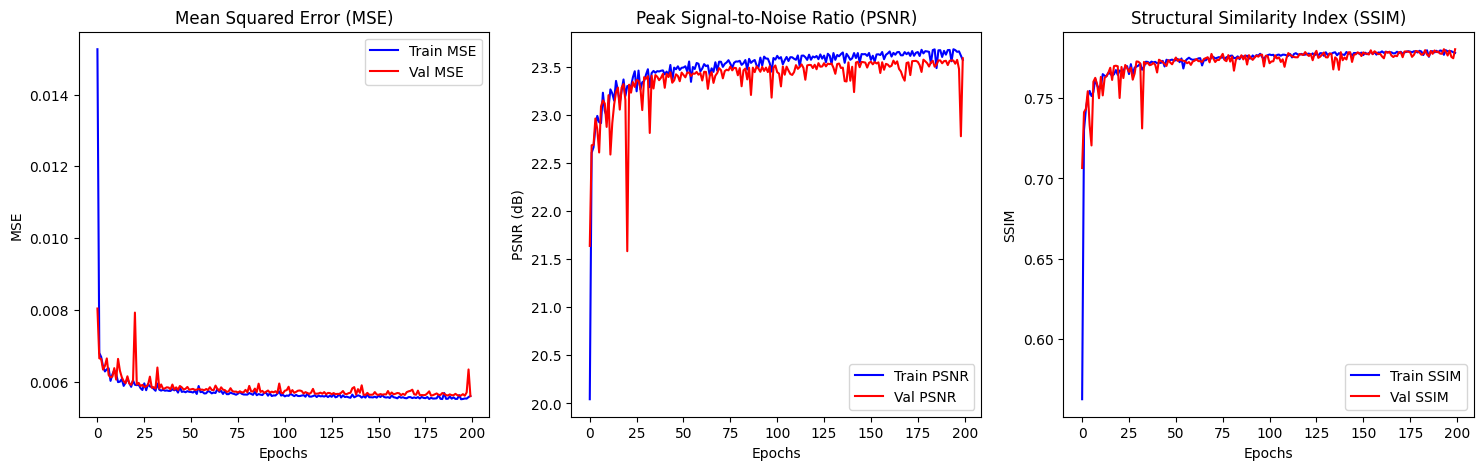

In [8]:
# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Loss Over Time")
plt.show()

# Super-Resolution Inference
def predict_sr(model, lr_image):
    lr_image = np.expand_dims(lr_image, axis=0)  # Add Batch Dimension
    sr_image = model.predict(lr_image)[0]  # Remove Batch Dimension
    return np.clip(sr_image, 0, 1)  # Clip Values Between 0-1

# Select a Sample Image
sample_lr = valid_lr[0]
sample_hr = valid_hr[0]
sample_sr = predict_sr(model, sample_lr)

# Calculate PSNR & SSIM
psnr_value = psnr(sample_hr, sample_sr)
ssim_value = ssim(sample_hr, sample_sr, data_range=1.0, channel_axis=-1, win_size=3)

# Show Results
fig, axes = plt.subplots(1, 3, figsize=(20, 12))
axes[0].imshow(sample_lr)
axes[0].set_title("Low Resolution")
axes[1].imshow(sample_sr)
axes[1].set_title(f"Super-Resolution\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")
axes[2].imshow(sample_hr)
axes[2].set_title("High Resolution (Ground Truth)")
plt.show()

#Evaluation Metrics
def plot_training_metrics(history):
    """Plot MSE, PSNR, and SSIM over epochs."""
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Plot MSE (Loss)
    ax[0].plot(history.history['loss'], label='Train MSE', color='blue')
    ax[0].plot(history.history['val_loss'], label='Val MSE', color='red')
    ax[0].set_title("Mean Squared Error (MSE)")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("MSE")
    ax[0].legend()

    # Plot PSNR
    if 'psnr_metric' in history.history:
        ax[1].plot(history.history['psnr_metric'], label='Train PSNR', color='blue')
        ax[1].plot(history.history['val_psnr_metric'], label='Val PSNR', color='red')
        ax[1].set_title("Peak Signal-to-Noise Ratio (PSNR)")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("PSNR (dB)")
        ax[1].legend()

    # Plot SSIM
    if 'ssim_metric' in history.history:
        ax[2].plot(history.history['ssim_metric'], label='Train SSIM', color='blue')
        ax[2].plot(history.history['val_ssim_metric'], label='Val SSIM', color='red')
        ax[2].set_title("Structural Similarity Index (SSIM)")
        ax[2].set_xlabel("Epochs")
        ax[2].set_ylabel("SSIM")
        ax[2].legend()

    plt.show()
plot_training_metrics(history)


With Data Augmentation

In [9]:
# import albumentations as A

# # Define Augmentations (Mild Adjustments)
# augmentor = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Rotate(limit=5, p=0.3),  # Small rotation
#     A.GaussNoise(var_limit=(10.0, 50.0), p=0.2)  # Light noise
# ])



In [31]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
    A.ImageCompression(quality_lower=85, quality_upper=100, p=0.4),
    A.RandomGamma(p=0.3),
    A.HueSaturationValue(p=0.3),
])



In [32]:
# Load High-Resolution Images
def load_images(image_paths, size=(256, 256)):
    images = []
    for img_path in sorted(glob.glob(image_paths)):  # ✅ Sort to ensure order
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        if(image_paths != '/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR/*.png'):
            images.append(img)
            continue
        # Apply augmentation
        augmented = augmentor(image=img)['image']
        
        images.append(augmented)
    return np.array(images, dtype=np.float32) / 255.0  # Normalize to [0,1]

# # Load Dataset
# train_hr = load_images(train_hr_path)
# valid_hr = load_images(valid_hr_path)

# print(f"✅ Loaded {len(train_hr)} Training Images & {len(valid_hr)} Validation Images")



In [33]:
# Generate Low-Resolution Images (Bicubic Downscaling)
def downscale_images(images, scale):
    lr_images = []
    for img in images:
        h, w, _ = img.shape
        img_lr = cv2.resize(img, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
        lr_images.append(img_lr.astype(np.float32))  # ✅ Ensure float32
    return np.array(lr_images, dtype=np.float32)

# train_lr = downscale_images(train_hr, scale=2)
# valid_lr = downscale_images(valid_hr, scale=2)

# # Check Image Shapes
# print(f"HR Shape: {train_hr.shape}, LR Shape: {train_lr.shape}")

# # Reshape HR & LR Images to Match Model Input
# train_lr = train_lr.reshape(-1, 128, 128, 3)  # ✅ Ensure correct shape
# train_hr = train_hr.reshape(-1, 256, 256, 3)  # ✅ Ensure correct shape

# valid_lr = valid_lr.reshape(-1, 128, 128, 3)
# valid_hr = valid_hr.reshape(-1, 256, 256, 3)

# print(f"✅ Reshaped HR: {train_hr.shape}, Reshaped LR: {train_lr.shape}")

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class SubpixelUpscale(Layer):
    def __init__(self, scale, **kwargs):
        super(SubpixelUpscale, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def compute_output_shape(self, input_shape):
        batch, h, w, c = input_shape
        return (
            batch,
            None if h is None else h * self.scale,
            None if w is None else w * self.scale,
            c // (self.scale ** 2)
        )

    def get_config(self):
        config = super(SubpixelUpscale, self).get_config()
        config.update({"scale": self.scale})
        return config


In [29]:


class CastToFloat32(Layer):
    def call(self, inputs):
        return tf.cast(inputs, tf.float32)

    def get_config(self):
        base_config = super().get_config()
        return base_config


In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda
from tensorflow.keras.models import Model

# Define ESPCN Model
def espcn_model(scale=2):
    inputs = Input(shape=(None, None, 3))
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(3 * (scale ** 2), (3, 3), activation='relu', padding='same')(x)
    x = SubpixelUpscale(scale)(x)
    #x = Lambda(lambda x: tf.nn.depth_to_space(x, scale))(x)  # Subpixel Shuffle
    #x = Lambda(lambda x: tf.nn.depth_to_space(x, scale),output_shape=lambda input_shape: (input_shape[0], input_shape[1]*scale, input_shape[2]*scale, input_shape[3] // (scale ** 2)))(x)
    x = CastToFloat32()(x)
    #x = Lambda(lambda x: tf.cast(x, tf.float32))(x)  # ✅ Ensure output is float32
    model = Model(inputs, x)
    return model



import tensorflow as tf
import tensorflow.image as tfimg
import keras.backend as K

# Define PSNR Metric
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Define SSIM Metric
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)


# Initialize Model
model = espcn_model(scale=2)


model.compile(optimizer='adam', loss='mse',
              metrics=['mse', 
                       tf.keras.metrics.MeanAbsoluteError(name='mae'), 
                       psnr_metric, 
                       ssim_metric])


model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_7 (Cast)                        │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, None, None, 64)      │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, None, None, 12)      │           3,468 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subpixel_upscale_7 (SubpixelUpscale) │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_7 (CastToFloat32)    │ (None, None, None, 3)       │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,796 (104.67 KB)

 Trainable params: 26,796 (104.67 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training ESPCN Model for x2 Upscaling...

✅ Finished Training for x2, Best model saved to espcn_model_x2.keras

Evaluation Metrics
For Scale 2


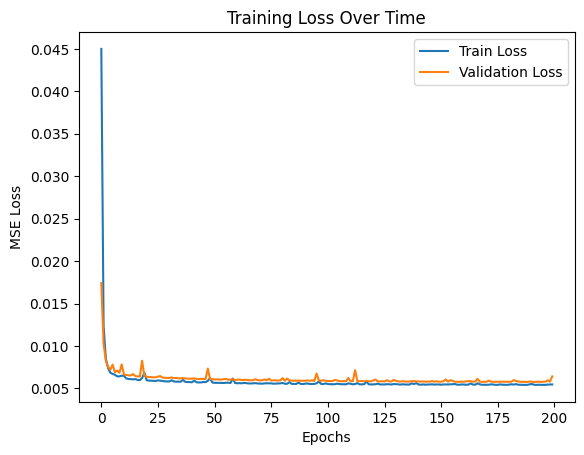

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


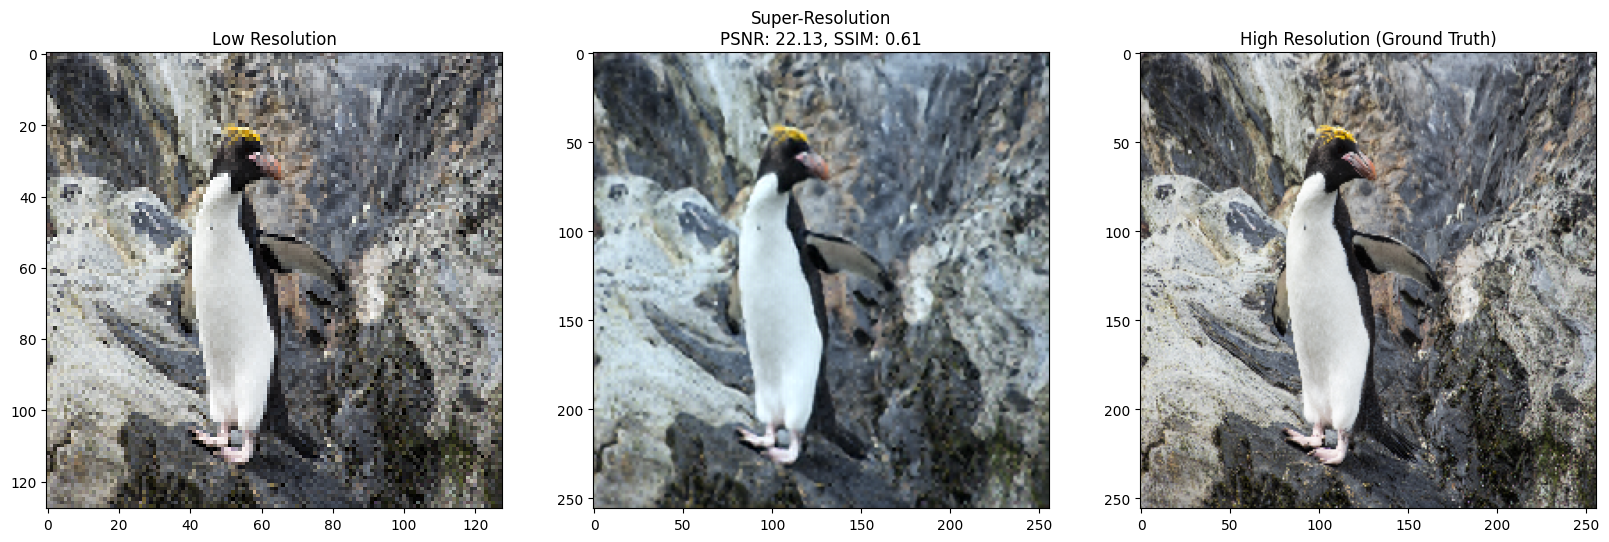

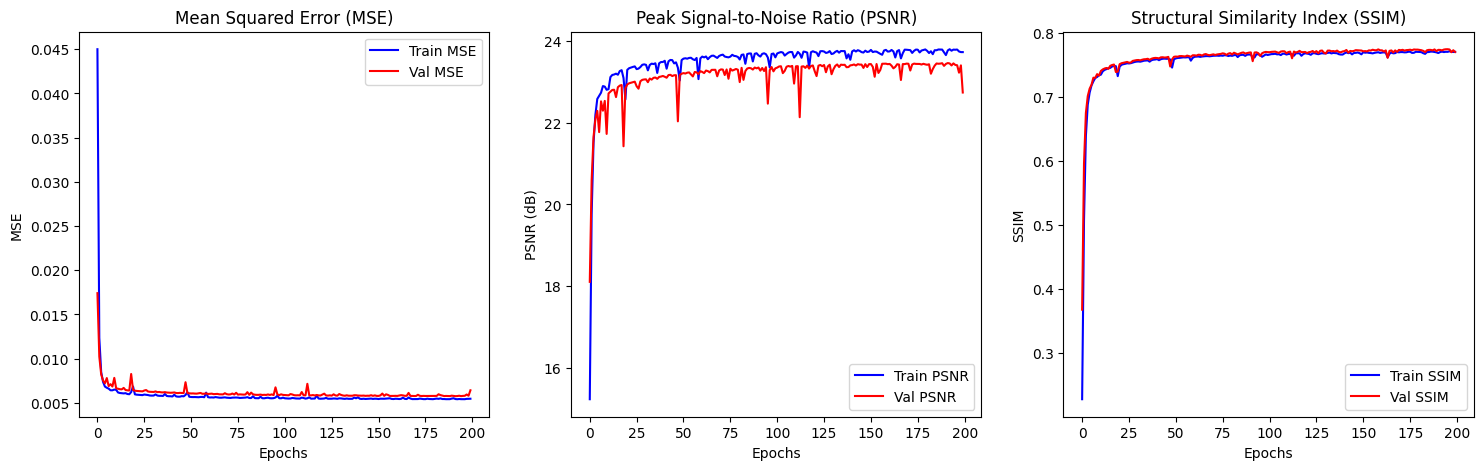


🚀 Training ESPCN Model for x4 Upscaling...

✅ Finished Training for x4, Best model saved to espcn_model_x4.keras

Evaluation Metrics
For Scale 4


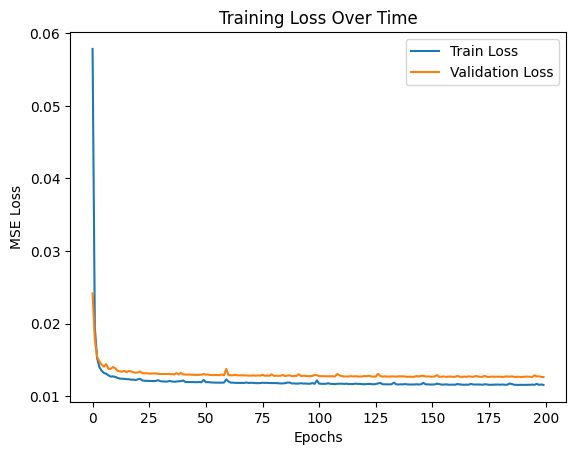

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


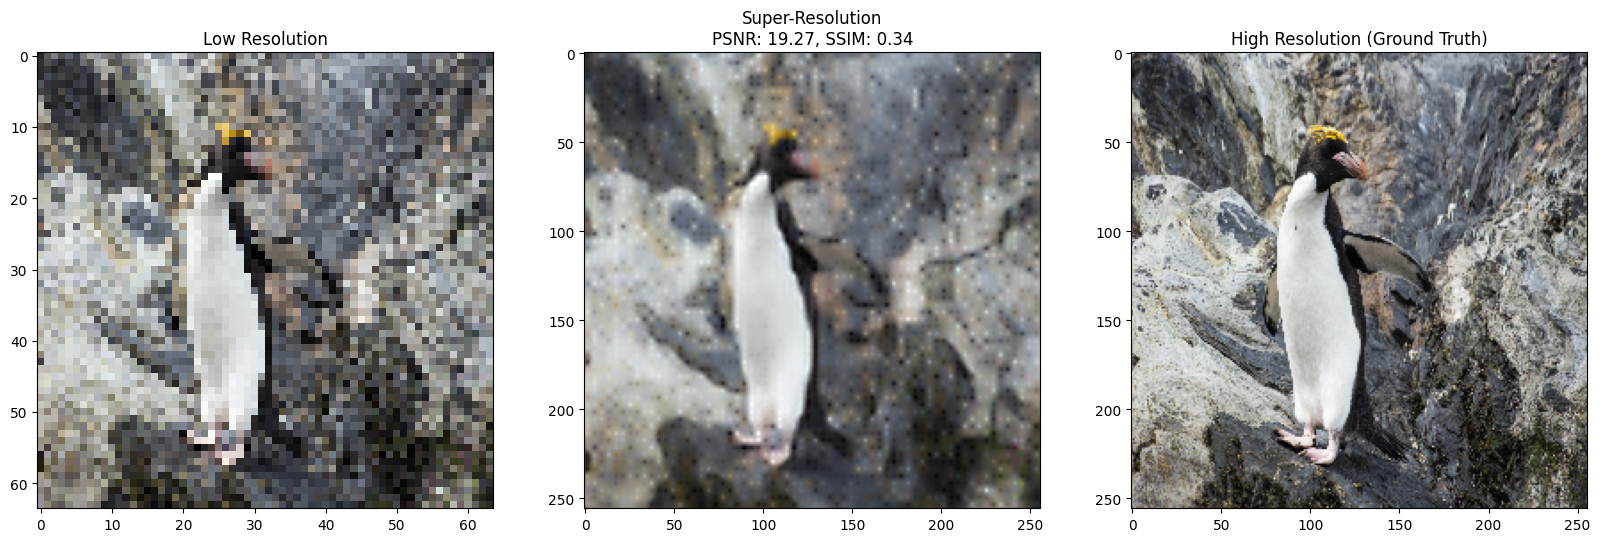

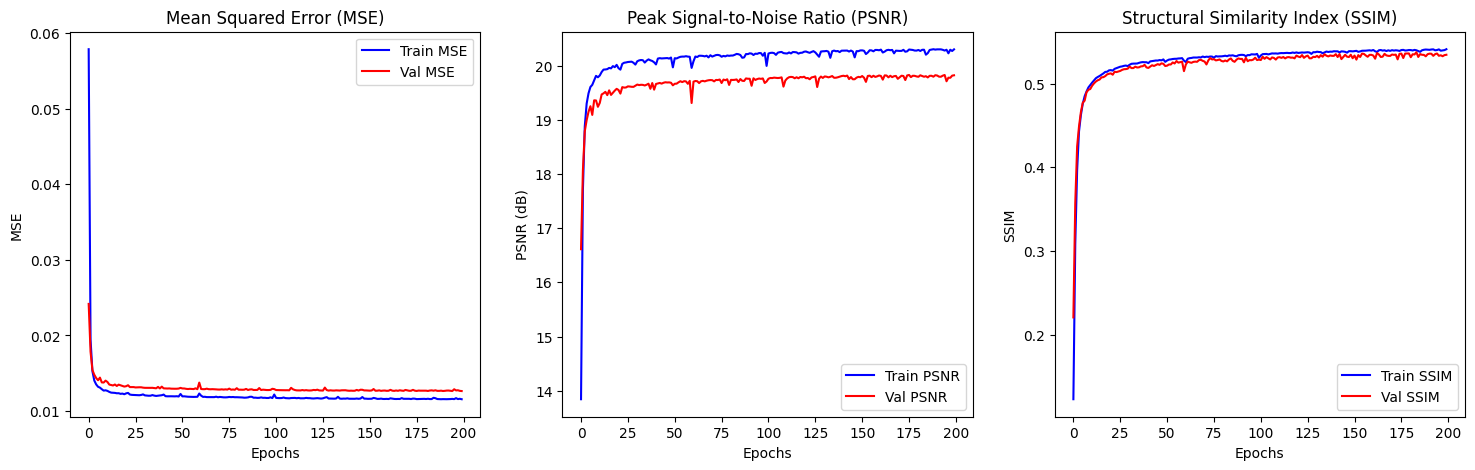


🚀 Training ESPCN Model for x8 Upscaling...

✅ Finished Training for x8, Best model saved to espcn_model_x8.keras

Evaluation Metrics
For Scale 8


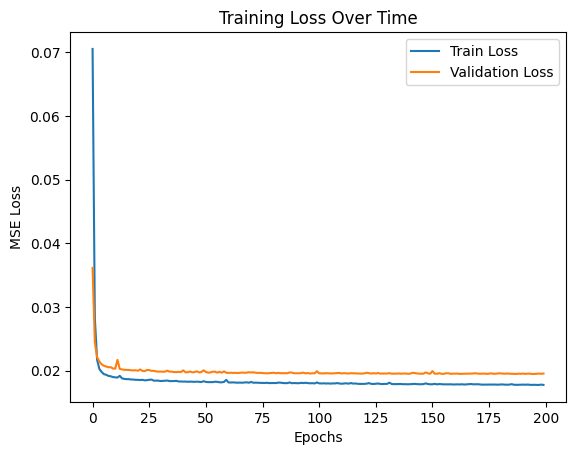

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


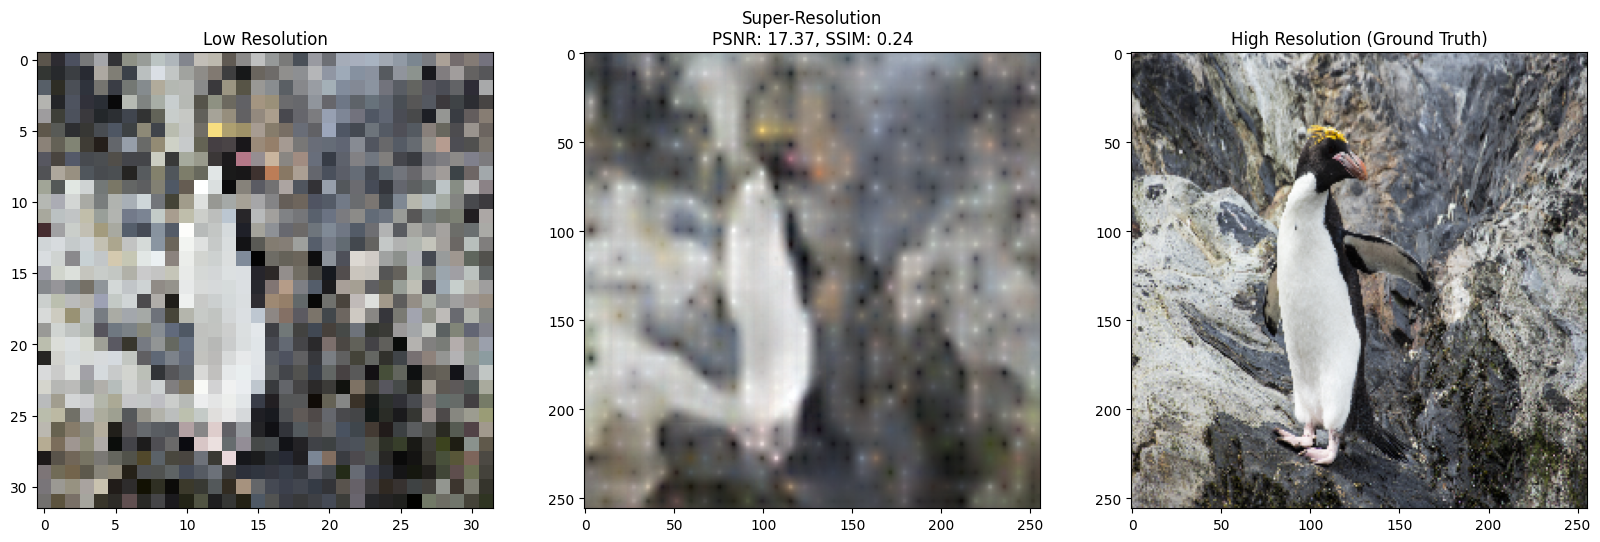

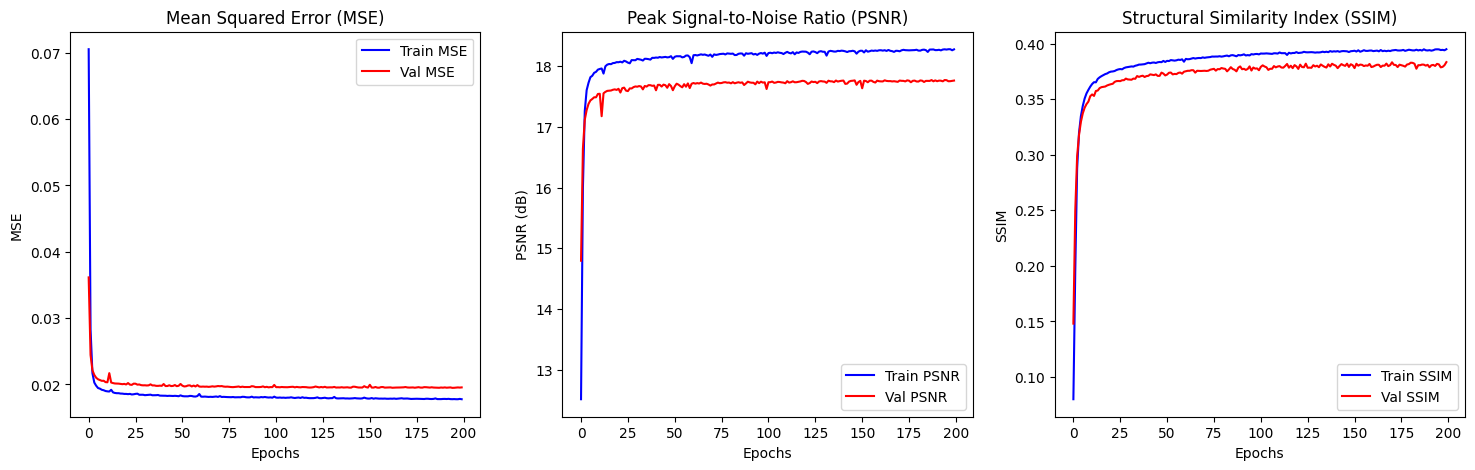

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint
for scale in [2, 4, 8]:
    print(f"\n🚀 Training ESPCN Model for x{scale} Upscaling...\n")

   # 🔁 Reload HR images fresh for each scale
    train_hr = load_images(train_hr_path)
    valid_hr = load_images(valid_hr_path)

    # 🔽 Generate corresponding LR images
    train_lr = downscale_images(train_hr, scale=scale)
    valid_lr = downscale_images(valid_hr, scale=scale)
    
    hr_size = 256
    lr_size = hr_size // scale

    train_lr_scaled = train_lr.reshape(-1, lr_size, lr_size, 3)
    train_hr_scaled = train_hr.reshape(-1, hr_size, hr_size, 3)

    valid_lr_scaled = valid_lr.reshape(-1, lr_size, lr_size, 3)
    valid_hr_scaled = valid_hr.reshape(-1, hr_size, hr_size, 3)

    # Create model for the current scale
    model = espcn_model(scale=scale)
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[
            'mse',
            tf.keras.metrics.MeanAbsoluteError(name='mae'),
            psnr_metric,
            ssim_metric
        ]
    )

    # Checkpoint name with scale in it
    checkpoint_path = f"espcn_model_x{scale}.keras"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=0)
    
    history = model.fit(
        x=train_lr_scaled,
        y=train_hr_scaled,
        validation_data=(valid_lr_scaled, valid_hr_scaled),
        batch_size=16,
        epochs=200,
        shuffle=True,
        callbacks=[checkpoint],
        verbose = 0
    )
 
    # Save the model and training plots
    print(f"✅ Finished Training for x{scale}, Best model saved to {checkpoint_path}\n")
    #plot_training_metrics(history)


    print("Evaluation Metrics")
    if scale == 2:
        history_x2 = history
        print("For Scale 2")
    elif scale == 4:
        history_x4 = history
        print("For Scale 4")
    else:
        history_x8 = history
        print("For Scale 8")

    # Plot Training Loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training Loss Over Time")
    plt.show()
    
    # Super-Resolution Inference
    def predict_sr(model, lr_image):
        lr_image = np.expand_dims(lr_image, axis=0)  # Add Batch Dimension
        sr_image = model.predict(lr_image)[0]  # Remove Batch Dimension
        return np.clip(sr_image, 0, 1)  # Clip Values Between 0-1
    
    # Select a Sample Image
    sample_lr = valid_lr[0]
    sample_hr = valid_hr[0]
    sample_sr = predict_sr(model, sample_lr)
    
    # Calculate PSNR & SSIM
    psnr_value = psnr(sample_hr, sample_sr)
    ssim_value = ssim(sample_hr, sample_sr, data_range=1.0, channel_axis=-1, win_size=3)
    
    # Show Results
    fig, axes = plt.subplots(1, 3, figsize=(20, 12))
    axes[0].imshow(sample_lr)
    axes[0].set_title("Low Resolution")
    axes[1].imshow(sample_sr)
    axes[1].set_title(f"Super-Resolution\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")
    axes[2].imshow(sample_hr)
    axes[2].set_title("High Resolution (Ground Truth)")
    plt.show()
    
    #Evaluation Metrics
    def plot_training_metrics(history):
        """Plot MSE, PSNR, and SSIM over epochs."""
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
        # Plot MSE (Loss)
        ax[0].plot(history.history['loss'], label='Train MSE', color='blue')
        ax[0].plot(history.history['val_loss'], label='Val MSE', color='red')
        ax[0].set_title("Mean Squared Error (MSE)")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("MSE")
        ax[0].legend()
    
        # Plot PSNR
        if 'psnr_metric' in history.history:
            ax[1].plot(history.history['psnr_metric'], label='Train PSNR', color='blue')
            ax[1].plot(history.history['val_psnr_metric'], label='Val PSNR', color='red')
            ax[1].set_title("Peak Signal-to-Noise Ratio (PSNR)")
            ax[1].set_xlabel("Epochs")
            ax[1].set_ylabel("PSNR (dB)")
            ax[1].legend()
    
        # Plot SSIM
        if 'ssim_metric' in history.history:
            ax[2].plot(history.history['ssim_metric'], label='Train SSIM', color='blue')
            ax[2].plot(history.history['val_ssim_metric'], label='Val SSIM', color='red')
            ax[2].set_title("Structural Similarity Index (SSIM)")
            ax[2].set_xlabel("Epochs")
            ax[2].set_ylabel("SSIM")
            ax[2].legend()
    
        plt.show()
    plot_training_metrics(history)

    

✅ Loaded 800 Training Images & 100 Validation Images
HR Shape: (800, 256, 256, 3), LR Shape: (800, 128, 128, 3)
✅ Reshaped HR: (800, 256, 256, 3), Reshaped LR: (800, 128, 128, 3)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_12 (Cast)                       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, None, None, 64)      │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, None, None, 12)      │           3,468 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subpixel_upscale_12                  │ (None, None, None, 3)       │               0 │
│ (SubpixelUpscale)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_12 (CastToFloat32)   │ (None, None, None, 3)       │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,796 (104.67 KB)

 Trainable params: 26,796 (104.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0826 - mae: 0.2009 - mse: 0.0826 - psnr_metric: 12.8089 - ssim_metric: 0.1453
Epoch 1: val_loss improved from inf to 0.01714, saving model to espcn_model_best_aug.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0818 - mae: 0.1998 - mse: 0.0818 - psnr_metric: 12.8615 - ssim_metric: 0.1471 - val_loss: 0.0171 - val_mae: 0.0909 - val_mse: 0.0171 - val_psnr_metric: 18.1744 - val_ssim_metric: 0.3917
Epoch 2/200
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0143 - mae: 0.0806 - mse: 0.0143 - psnr_metric: 19.0734 - ssim_metric: 0.4540
Epoch 2: val_loss improved from 0.01714 to 0.01071, saving model to espcn_model_best_aug.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0142 - mae: 0.0803 - mse: 0.0142 - psnr_metric: 19.0986 - ssim_metric: 0.4559 - val_loss: 0.0107 - val_mae: 0.0689 - val_mse: 0.0107 - val_psnr_metric: 20.3704 - val_ssim_metric: 0.5819
Epoch 3/200
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.

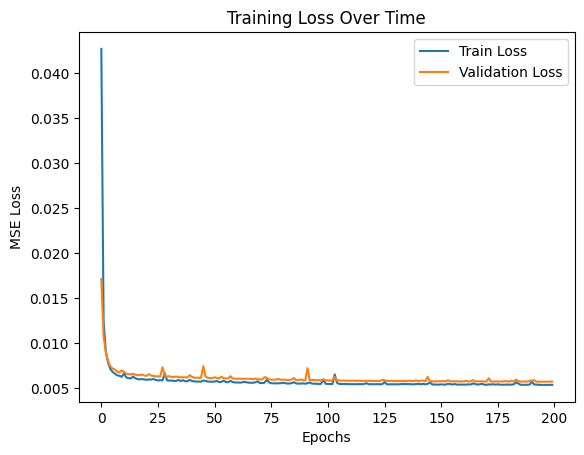

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


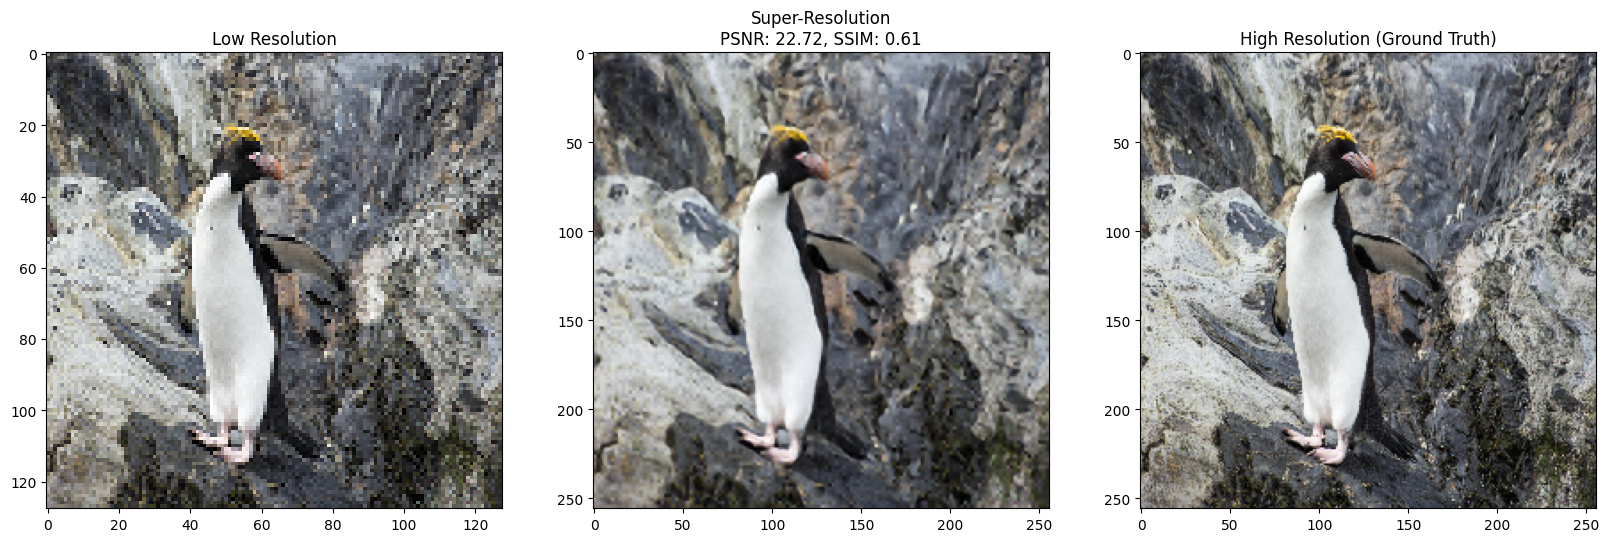

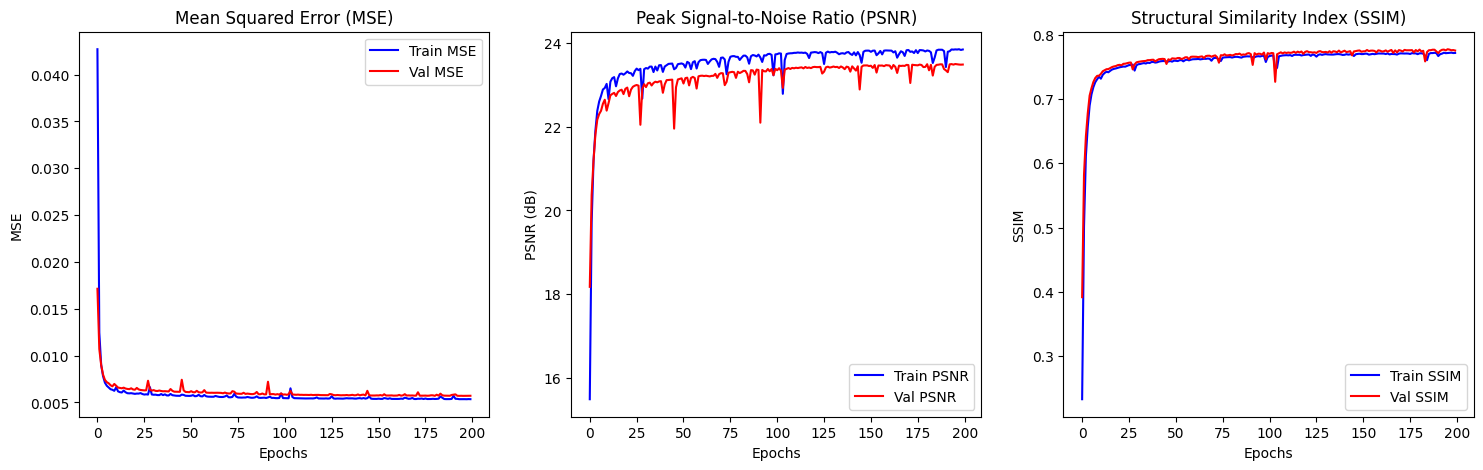

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
SR min: 0.0 max: 1.0722656


In [39]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
    A.ImageCompression(quality_lower=85, quality_upper=100, p=0.4),
    A.RandomGamma(p=0.3),
    A.HueSaturationValue(p=0.3),
])

# Load High-Resolution Images
def load_images(image_paths, size=(256, 256)):
    images = []
    for img_path in sorted(glob.glob(image_paths)):  # ✅ Sort to ensure order
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        if(image_paths != '/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR/*.png'):
            images.append(img)
            continue
        # Apply augmentation
        augmented = augmentor(image=img)['image']

        images.append(augmented)
    return np.array(images, dtype=np.float32) / 255.0  # Normalize to [0,1]

# Load Dataset
train_hr = load_images(train_hr_path)
valid_hr = load_images(valid_hr_path)

print(f"✅ Loaded {len(train_hr)} Training Images & {len(valid_hr)} Validation Images")



# Generate Low-Resolution Images (Bicubic Downscaling)
def downscale_images(images, scale=2):
    lr_images = []
    for img in images:
        h, w, _ = img.shape
        img_lr = cv2.resize(img, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
        lr_images.append(img_lr.astype(np.float32))  # ✅ Ensure float32
    return np.array(lr_images, dtype=np.float32)

train_lr = downscale_images(train_hr, scale=2)
valid_lr = downscale_images(valid_hr, scale=2)

# Check Image Shapes
print(f"HR Shape: {train_hr.shape}, LR Shape: {train_lr.shape}")

# Reshape HR & LR Images to Match Model Input
train_lr = train_lr.reshape(-1, 128, 128, 3)  # ✅ Ensure correct shape
train_hr = train_hr.reshape(-1, 256, 256, 3)  # ✅ Ensure correct shape

valid_lr = valid_lr.reshape(-1, 128, 128, 3)
valid_hr = valid_hr.reshape(-1, 256, 256, 3)

print(f"✅ Reshaped HR: {train_hr.shape}, Reshaped LR: {train_lr.shape}")

class SubpixelUpscale(Layer):
    def __init__(self, scale, **kwargs):
        super(SubpixelUpscale, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def compute_output_shape(self, input_shape):
        batch, h, w, c = input_shape
        return (
            batch,
            None if h is None else h * self.scale,
            None if w is None else w * self.scale,
            c // (self.scale ** 2)
        )

    def get_config(self):
        config = super(SubpixelUpscale, self).get_config()
        config.update({"scale": self.scale})
        return config

import tensorflow as tf
from tensorflow.keras.layers import Layer

class CastToFloat32(Layer):
    def call(self, inputs):
        return tf.cast(inputs, tf.float32)

    def get_config(self):
        base_config = super().get_config()
        return base_config

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Lambda
from tensorflow.keras.models import Model

# Define ESPCN Model
def espcn_model(scale=2):
    inputs = Input(shape=(None, None, 3))
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(3 * (scale ** 2), (3, 3), activation='relu', padding='same')(x)
    x = SubpixelUpscale(scale)(x)
    #x = Lambda(lambda x: tf.nn.depth_to_space(x, scale))(x)  # Subpixel Shuffle
    #x = Lambda(lambda x: tf.nn.depth_to_space(x, scale),output_shape=lambda input_shape: (input_shape[0], input_shape[1]*scale, input_shape[2]*scale, input_shape[3] // (scale ** 2)))(x)
    x = CastToFloat32()(x)
    #x = Lambda(lambda x: tf.cast(x, tf.float32))(x)  # ✅ Ensure output is float32
    model = Model(inputs, x)
    return model



import tensorflow as tf
import tensorflow.image as tfimg
import keras.backend as K

# Define PSNR Metric
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Define SSIM Metric
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)


# Initialize Model
model = espcn_model(scale=2)


model.compile(optimizer='adam', loss='mse',
              metrics=['mse',
                       tf.keras.metrics.MeanAbsoluteError(name='mae'),
                       psnr_metric,
                       ssim_metric])


model.summary()

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import ReduceLROnPlateau

# 📉 Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # What to monitor
    factor=0.5,            # Reduce LR by a factor of 0.5
    patience=10,           # Wait 10 epochs before reducing
    min_lr=1e-6,           # Never go below this LR
    verbose=1
)

checkpoint_edsr = ModelCheckpoint("espcn_model_best_aug.keras", monitor="val_loss", save_best_only=True, verbose=1)
# Train the Model
history = model.fit(
    x=train_lr,               # LR input
    y=train_hr,               # HR target
    validation_data=(valid_lr, valid_hr),
    batch_size=16,
    epochs=200,
    shuffle=True,
    callbacks=[checkpoint_edsr]
)
# Save Model
#model.save("espcn_model_aug.h5")
#print("Model Saved Successfully!")

# # Train Model with Augmented Data
# history = model.fit(
#     train_generator,  # Augmented training data
#     epochs=100,       # Adjust as needed
#     validation_data=val_generator,  # Validation data

# )
# # steps_per_epoch=len(train_lr) // batch_size,
# # validation_steps=len(valid_lr) // batch_size
# # Save Model
# model.save("espcn_model_augm.h5")
# print("✅ Model Saved Successfully!")

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Loss Over Time")
plt.show()

# Super-Resolution Inference
def predict_sr(model, lr_image):
    lr_image = np.expand_dims(lr_image, axis=0)  # Add Batch Dimension
    sr_image = model.predict(lr_image)[0]  # Remove Batch Dimension
    return np.clip(sr_image, 0, 1)  # Clip Values Between 0-1

# Select a Sample Image
sample_lr = valid_lr[0]
sample_hr = valid_hr[0]
sample_sr = predict_sr(model, sample_lr)

# Calculate PSNR & SSIM
psnr_value = psnr(sample_hr, sample_sr)
ssim_value = ssim(sample_hr, sample_sr, data_range=1.0, channel_axis=-1, win_size=3)

# Show Results
fig, axes = plt.subplots(1, 3, figsize=(20, 12))
axes[0].imshow(sample_lr)
axes[0].set_title("Low Resolution")
axes[1].imshow(sample_sr)
axes[1].set_title(f"Super-Resolution\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")
axes[2].imshow(sample_hr)
axes[2].set_title("High Resolution (Ground Truth)")
plt.show()

#Evaluation Metrics
def plot_training_metrics(history):
    """Plot MSE, PSNR, and SSIM over epochs."""
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Plot MSE (Loss)
    ax[0].plot(history.history['loss'], label='Train MSE', color='blue')
    ax[0].plot(history.history['val_loss'], label='Val MSE', color='red')
    ax[0].set_title("Mean Squared Error (MSE)")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("MSE")
    ax[0].legend()

    # Plot PSNR
    if 'psnr_metric' in history.history:
        ax[1].plot(history.history['psnr_metric'], label='Train PSNR', color='blue')
        ax[1].plot(history.history['val_psnr_metric'], label='Val PSNR', color='red')
        ax[1].set_title("Peak Signal-to-Noise Ratio (PSNR)")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("PSNR (dB)")
        ax[1].legend()

    # Plot SSIM
    if 'ssim_metric' in history.history:
        ax[2].plot(history.history['ssim_metric'], label='Train SSIM', color='blue')
        ax[2].plot(history.history['val_ssim_metric'], label='Val SSIM', color='red')
        ax[2].set_title("Structural Similarity Index (SSIM)")
        ax[2].set_xlabel("Epochs")
        ax[2].set_ylabel("SSIM")
        ax[2].legend()

    plt.show()
plot_training_metrics(history)

sample_sr = model.predict(np.expand_dims(sample_lr, axis=0))[0]
print("SR min:", sample_sr.min(), "max:", sample_sr.max())



In [2]:
# # Train Model with Augmented Data
# history = model.fit(
#     train_generator,  # Augmented training data
#     epochs=100,       # Adjust as needed
#     validation_data=val_generator,  # Validation data
    
# )
# # steps_per_epoch=len(train_lr) // batch_size,
# # validation_steps=len(valid_lr) // batch_size
# # Save Model
# model.save("espcn_model_augm.h5")
# print("✅ Model Saved Successfully!")


History x2

In [19]:
sample_sr = model.predict(np.expand_dims(sample_lr, axis=0))[0]
print("SR min:", sample_sr.min(), "max:", sample_sr.max())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
SR min: 0.0 max: 1.0527344


EDSR